*August 8, 2018*

In the notebook of *"Manual Classification of delays"* I identified some figures, for example the following ones:

-----

### Gaussian-Like behavior

There is a *mean* and a *std* that could describe the major part of the data, as shown in this example

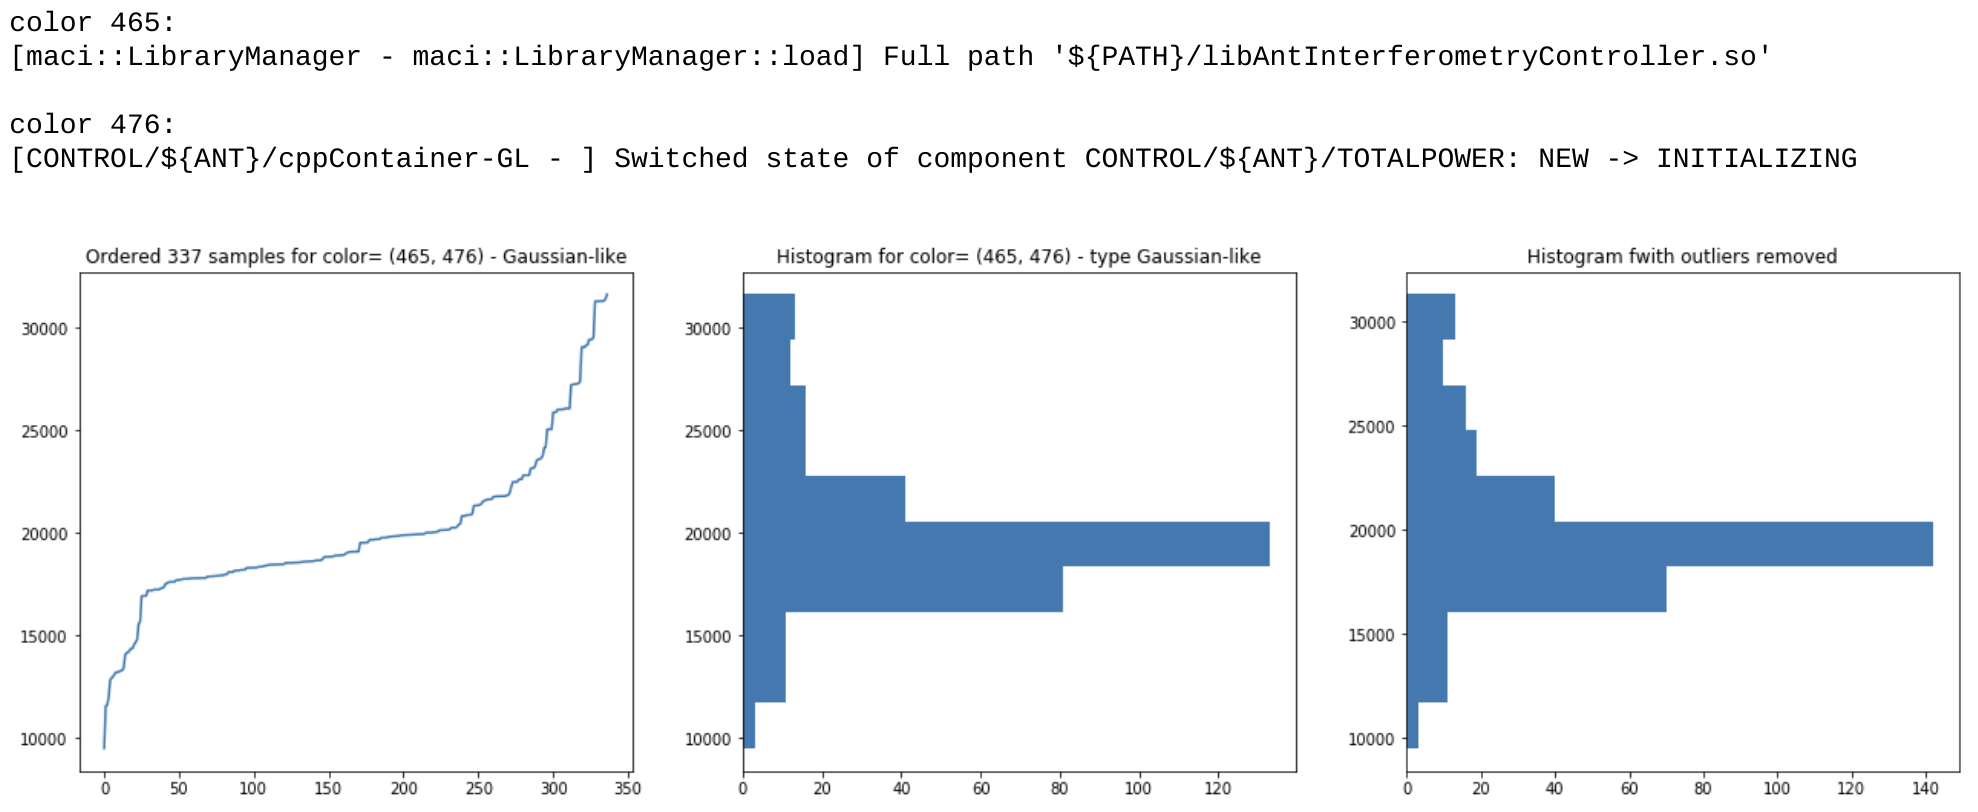

-----

### Leftist density

The processes between (a,b) takes a pretty constant amount of time, except by a small set of points spread evenly up to certain amount of extra delay.

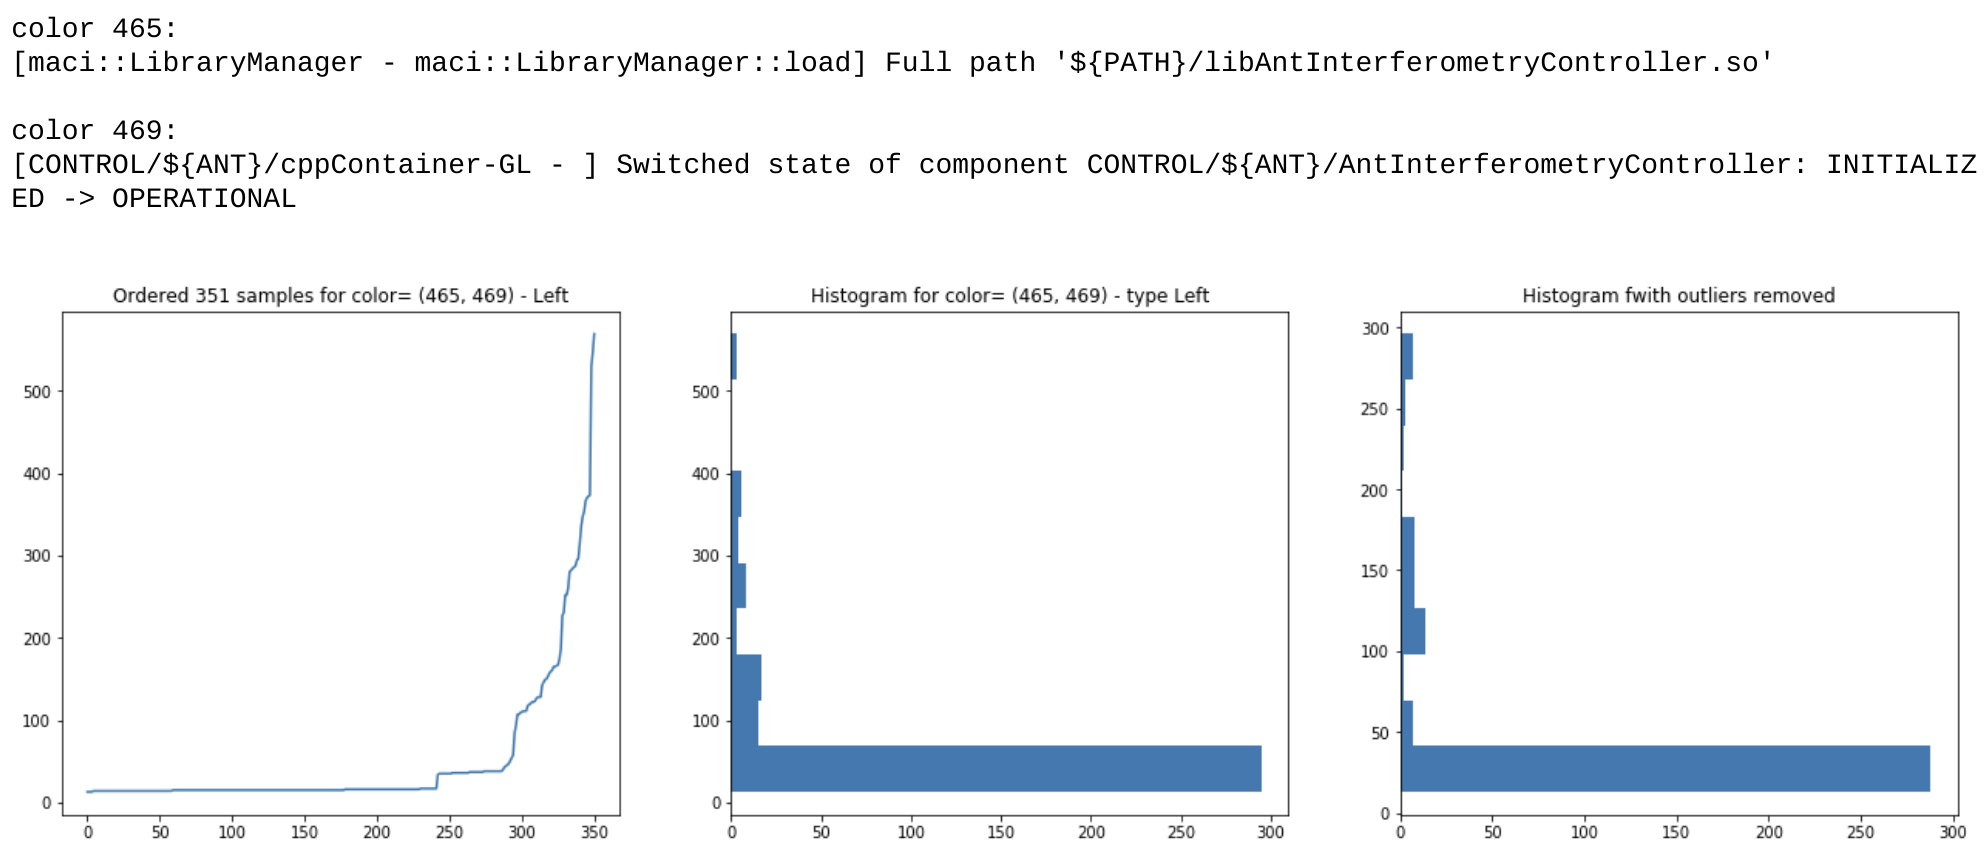

-----

### Pulse behavior, < 10ms

For practical purposes, all delays below a certain threshold, for example 10ms, could be thought as instantaneous.

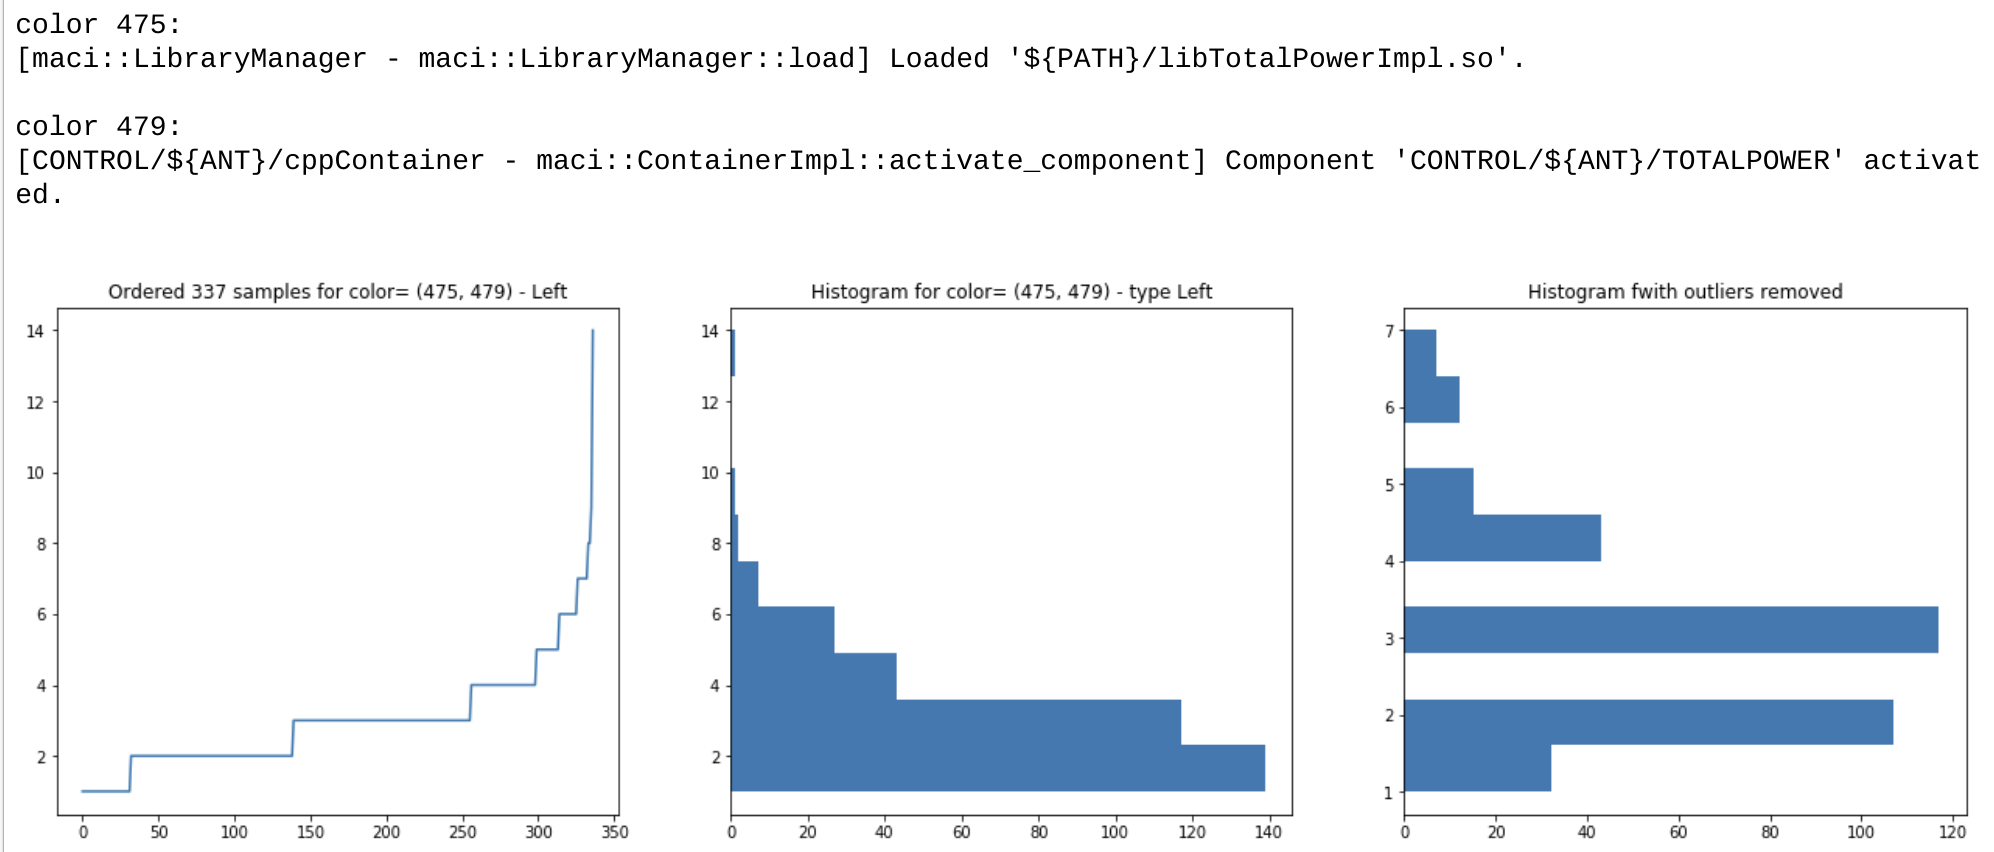

-----

### Composed behavior

This is a bit harder to understand, but in general one could think in adding two or more of the previous groups of behaviors. 

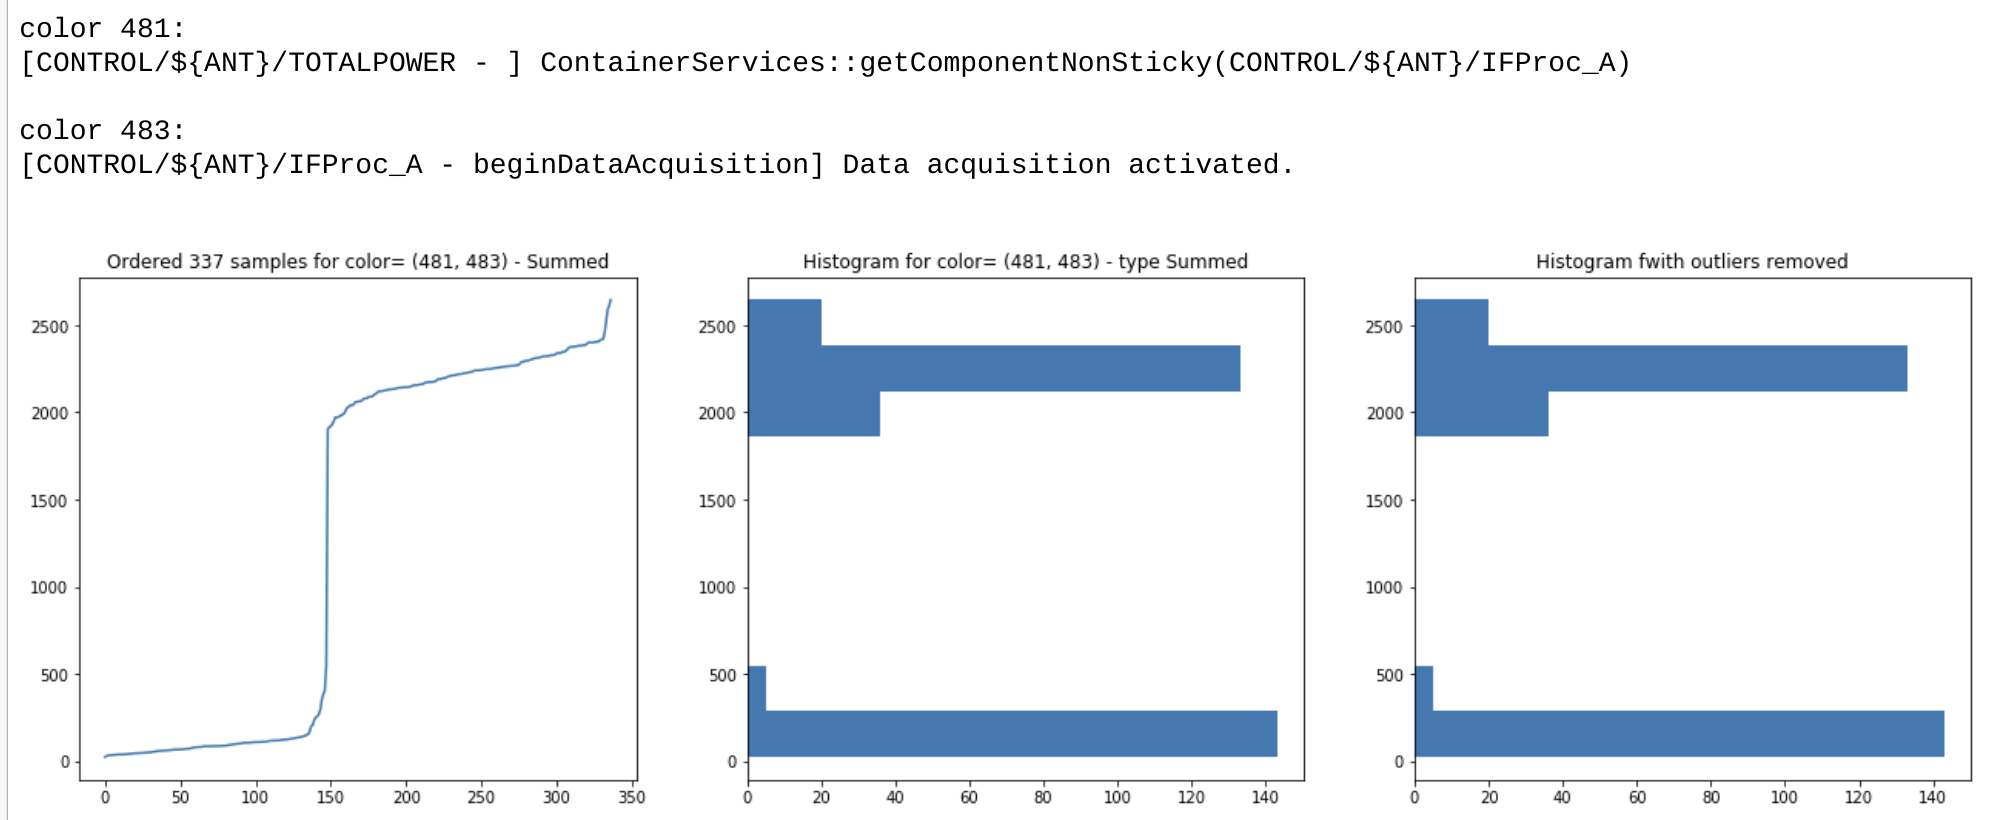

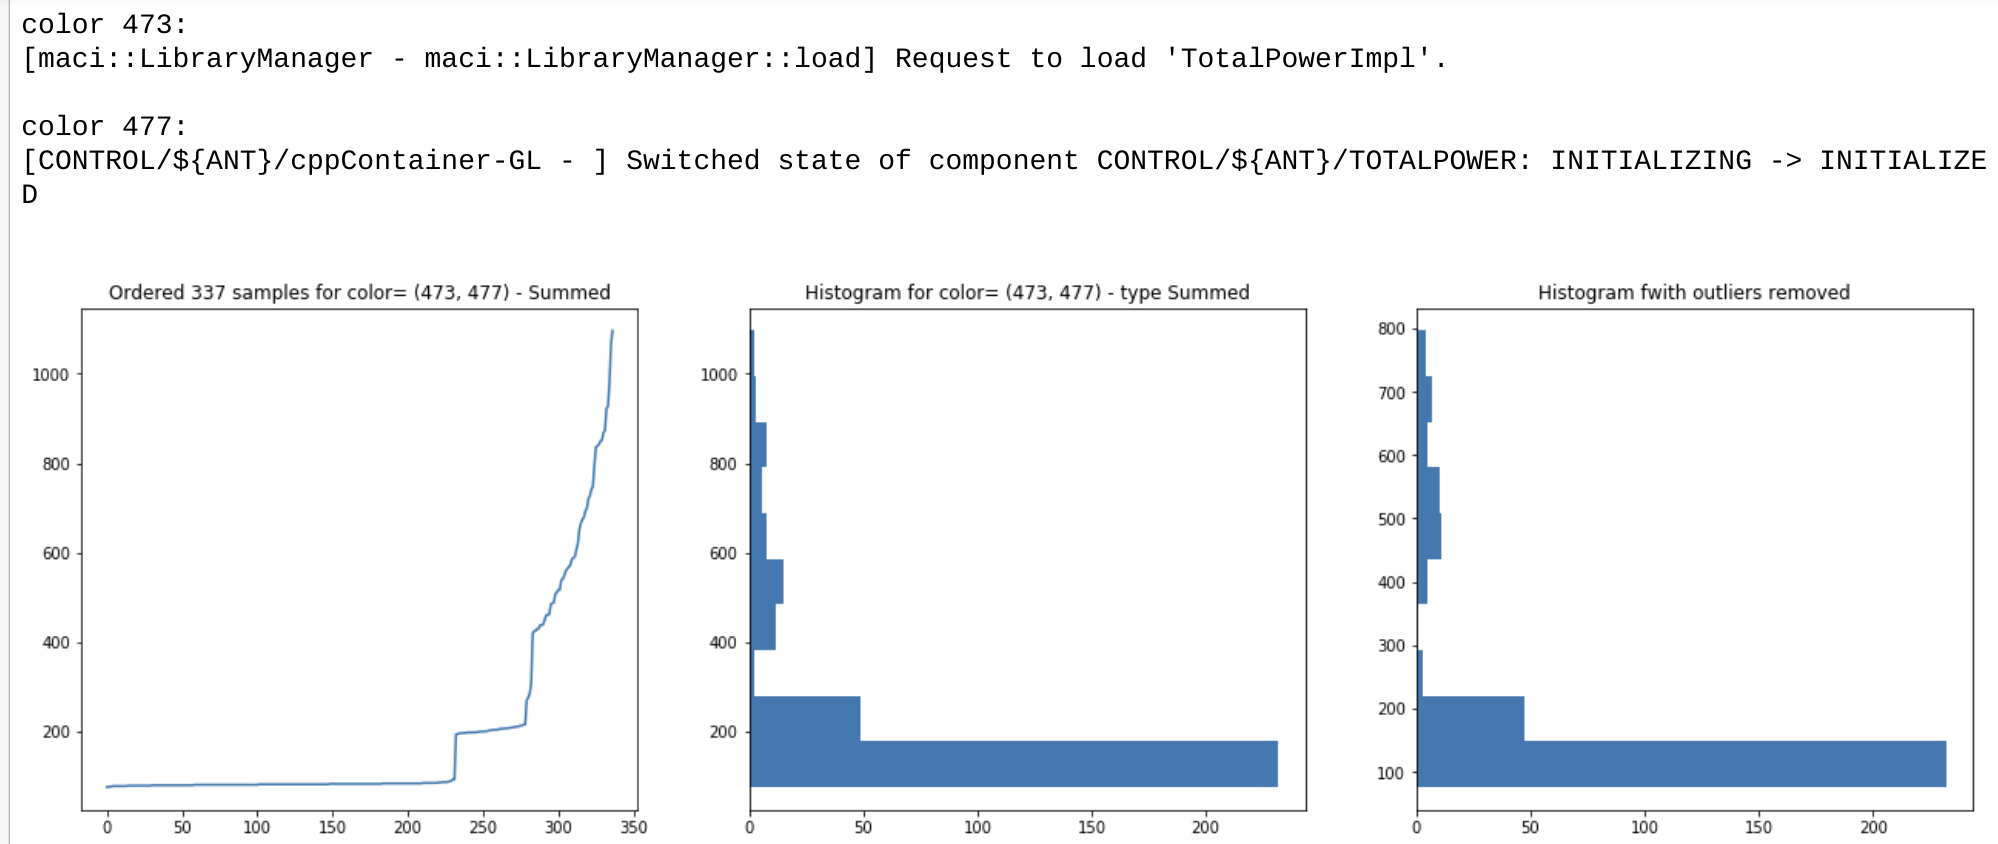

-----

## Pre processing

Given a set of delays from a set of cases previously computed, I applied another two pre-processing techniques:

1. Filter out sets with few samples, by manually setting the parameter *MIN_NUMBER_OF_SAMPLES* arbitrarily to 100
2. Use a light criteria for outlier remotion, just leaving in the set data between +-3 sigma of the mean. 

I'm not assuming a Gaussian distribution, but using that criteria to quickly remove very far points that would add innecessary noise to the found histograms.

# Correlating gaussian and lognormal shape

Let's work with the example of (465, 476) as seen in the first example above. Let's set up our Python environment first:

In [67]:
from src import *
from src.models.AlmaClasses import *
palette = PaletteFileDB(filename='../data/processed/colors-almaAntenna.pkl', colorFunction=paintedForAlmaAntennas )
colors=palette.getColors()
db = DelaysFileDB( caseName="CaseAntennaObserving", path= '../' + config.FILEPATH_DB+"/delays") 

%matplotlib inline
from pandas import Series

from matplotlib import pyplot
import matplotlib.pyplot as plt

import numpy as np
import scipy.stats

pyplot.rcParams["figure.figsize"] = (22,6)

In [122]:
# Function to remove possible outliers, up to sigma = 3
def remove_outliers(dataset, sigma=3):
    mean = np.mean(dataset, axis=0)
    sd = np.std(dataset, axis=0)
    return [ x for x in dataset if (x >= mean - 3.0 * sd) and (x <= mean + 3.0 * sd) ]

count      335.000000
mean     19983.659701
std       3672.374285
min       9505.000000
25%      18091.500000
50%      19087.000000
75%      21362.000000
max      31305.000000
dtype: float64


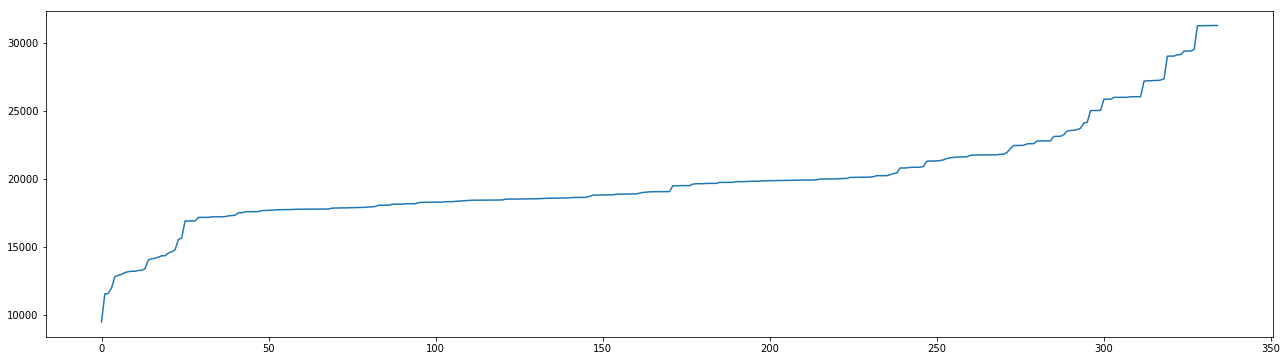

0.17071920696598497 -917.205990037987 20595.715918734946


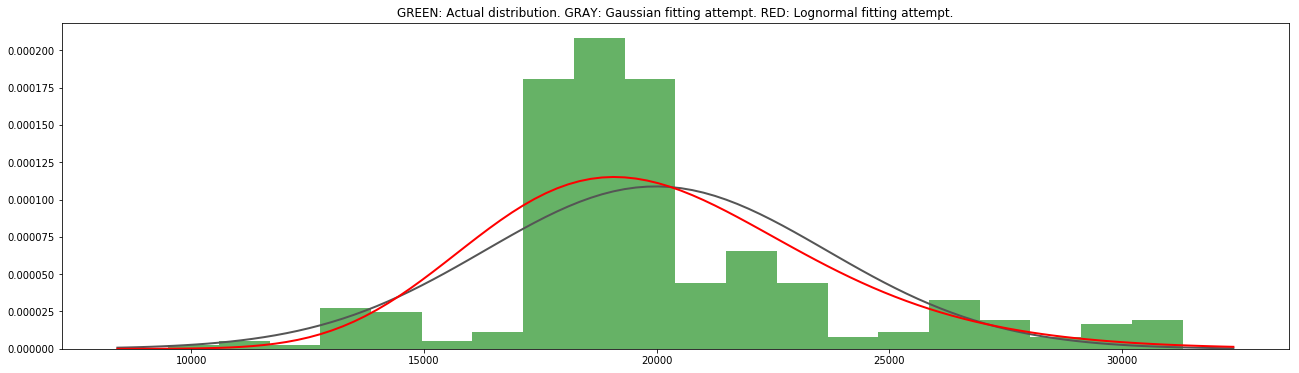

In [123]:
# This is my pair of interest, a Gaussian-like shape
a, b = 465, 476
s = remove_outliers( db.getDelays(a,b) )

print Series(s).describe()

plt.plot(sorted(s))
plt.show()

plt.hist(s, bins=20, density=True, alpha=0.6, color='g')


# Fit a normal distribution to the data:
mu, std = scipy.stats.norm.fit(s)

# Plot the PDF.99
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, color='#555555')

# Fit a lognormal distribution
shape, loc, scale = scipy.stats.lognorm.fit(s)
print shape, loc, scale
p2 = scipy.stats.lognorm.pdf(x, shape, loc=loc, scale=scale )
plt.plot(x, p2, linewidth=2, color='r')
plt.title("GREEN: Actual distribution. GRAY: Gaussian fitting attempt. RED: Lognormal fitting attempt.")
plt.show()

## Preliminary conclusion

This shape don't fit well into a Gaussian or a log-normal distribution. I need to keep searching ways to make it fit to something known.

# Identify pulse-like shapes
As we saw in the beginning of this doc, any dataset whose points falls in the interval *[0, PULSE_VALUE]* can be considered as individual pulses, very rapid messages that appears as a single step fast enough. This could be really the first  group of datasets to identify. Let's fix PULSE_VALUE:

In [124]:
PULSE_VALUE = 20  #milliseconds

Let's calculate the meaningful datasets now, for those datasets having at least 100 samples

In [125]:
MIN_NUMBER_OF_SAMPLES = 25
meaningfulPairs = {}
for (a,b) in db.pair_names():
    ipp = db._instances_per_pair[(a,b)]
    dpp = db._delays_per_pair[(a,b)]
    percen = 100.0*ipp/db.total_cases()
    
    if dpp >= MIN_NUMBER_OF_SAMPLES:    
        meaningfulPairs[(a,b)] = { 0:percen, 1:ipp,  2:dpp, 3:"---"}
        
# Add the manual classification here:

# Gaussian-Like:
for (a,b) in [ (464, 480), (465, 476), (465, 480), (466, 482), (466, 477), (468, 475), (468, 482), (469, 476), (470, 474), (470, 480), (472, 482), 
               (464, 482), (465, 473), (466, 480), (468, 478), (470, 477), (471, 478), (471, 480), (472, 477), (494, 505), (501, 503), (491, 495), 
               (402, 579), (492, 387) ]:
    meaningfulPairs[ (a, b) ][3] = "Gaussian-like"
    
# Left grouped
for (a,b) in [ (464, 469), (465, 469), (466, 468), (475, 479), (497, 498), (501, 505), (502, 504), (503, 504), (505, 506), 
               (400, 579), (464, 471), (465, 466), (473, 474), (476, 478), (511, 512), (505, 503) ]:
    meaningfulPairs[ (a, b) ][3] = "Left"

# Summed up, or two processes coupled 
for (a,b) in [ (473, 477), (474, 476), (474, 480), (477, 483), (478, 483), (480, 484), (481, 483), (481, 484), (495, 498) ]:
    meaningfulPairs[ (a, b) ][3] = "Summed"

# Curious!
for (a,b) in [ (468, 471), (493, 497) ]:
    meaningfulPairs[ (a, b) ][3] = "Curious"

# Any other
for (a,b) in [ (439, 487), (464, 487), (465, 495), (466, 515), (467, 400), (468, 514), (469, 498), (470, 515), (473, 498), (475, 487), (476, 486), (476, 495), (476, 497), (477, 497), (478, 486), (483, 500), (484, 402), (484, 495), (488, 402), (498, 514), 
               (580, 578), (464, 500), (469, 514), (467, 514), (471, 491), (471, 495), (474, 491), (475, 491), (478, 492), (479, 486), (497, 515), (480, 498), (469, 497), (470, 498), (479, 491), (479, 497), (476, 500), (466, 402), (477, 495), (474, 498), 
               (581, 580), (464, 400), (500, 514), (473, 486), (464, 491), (483, 497), (467, 402), (480, 495), (470, 495) ]:
    meaningfulPairs[ (a, b) ][3] = "Any-Other"

And now, let's iterate over all the datasets searching those behaving as pulse. Note that it may have been previously labelled with "Left", after manual inspection.

In [126]:
def multiplot(a, b):
    v = meaningfulPairs[(a,b)]
    print "color %s:" % a
    print colors[a]; print
    print "color %s:" % b
    print colors[b]; print
    fig, ax = pyplot.subplots(1,3)
    ax[0].plot( sorted( db.getDelays(a,b) ) )
    ax[0].set_title( "Ordered %d samples for color= (%s, %s) - %s" % (v[2], a, b, v[3]) )

    ax[1].hist(  db.getDelays(a,b), orientation='horizontal', bins=10 )
    ax[1].set_title( "Histogram for color= (%s, %s) - type %s" % (a, b, v[3]) )

    ax[2].hist( remove_outliers(db.getDelays(a,b)), orientation='horizontal', bins=10 )
    ax[2].set_title( "Outliers removed (3-sigma)" )

    pyplot.show()

In [127]:
for (a,b) in sorted(meaningfulPairs.keys()):
    dataset = remove_outliers( db.getDelays(a,b) )
    if len(dataset) == 0:
        print "What a strange world... %s %s has no data? --- %s" % (a, b, db.getDelays(a,b) )
    if max(dataset) <= PULSE_VALUE:
        maxPoint = max(dataset)
        was = meaningfulPairs[(a,b)][3]
        meaningfulPairs[(a,b)][3] = 'Pulse'
        v = meaningfulPairs[(a,b)]
        print "(%s, %s) \t %.1f \t %s \t %s \t %s (was %s) \t MAX=%d" % ( a, b, v[0], v[1],  v[2], v[3], was, maxPoint )

(395, 398) 	 6.6 	 23 	 46 	 Pulse (was ---) 	 MAX=1
(395, 400) 	 9.7 	 34 	 68 	 Pulse (was ---) 	 MAX=1
(395, 402) 	 11.4 	 40 	 80 	 Pulse (was ---) 	 MAX=2
(398, 400) 	 3.7 	 13 	 26 	 Pulse (was ---) 	 MAX=1
(398, 402) 	 6.0 	 21 	 42 	 Pulse (was ---) 	 MAX=2
(400, 402) 	 12.3 	 43 	 81 	 Pulse (was ---) 	 MAX=1
(464, 465) 	 100.0 	 351 	 351 	 Pulse (was ---) 	 MAX=5
(466, 467) 	 96.9 	 340 	 340 	 Pulse (was ---) 	 MAX=4
(466, 468) 	 98.3 	 345 	 345 	 Pulse (was Left) 	 MAX=4
(466, 469) 	 99.1 	 348 	 348 	 Pulse (was ---) 	 MAX=4
(466, 470) 	 100.0 	 351 	 351 	 Pulse (was ---) 	 MAX=6
(467, 468) 	 24.8 	 87 	 87 	 Pulse (was ---) 	 MAX=1
(467, 469) 	 39.9 	 140 	 140 	 Pulse (was ---) 	 MAX=2
(467, 470) 	 70.1 	 246 	 246 	 Pulse (was ---) 	 MAX=3
(468, 469) 	 27.9 	 98 	 98 	 Pulse (was ---) 	 MAX=1
(468, 470) 	 64.7 	 227 	 227 	 Pulse (was ---) 	 MAX=3
(469, 470) 	 55.6 	 195 	 195 	 Pulse (was ---) 	 MAX=3
(470, 471) 	 100.0 	 351 	 351 	 Pulse (was ---) 	 MAX=19
(471, 4

## A properties for Pulse datasets
An interesting property appears. If the path below (N=3) are made only by pulses:

color 475:
[maci::LibraryManager - maci::LibraryManager::load] Loaded '${PATH}/libTotalPowerImpl.so'.

color 477:
[CONTROL/${ANT}/cppContainer-GL - ] Switched state of component CONTROL/${ANT}/TOTALPOWER: INITIALIZING -> INITIALIZED



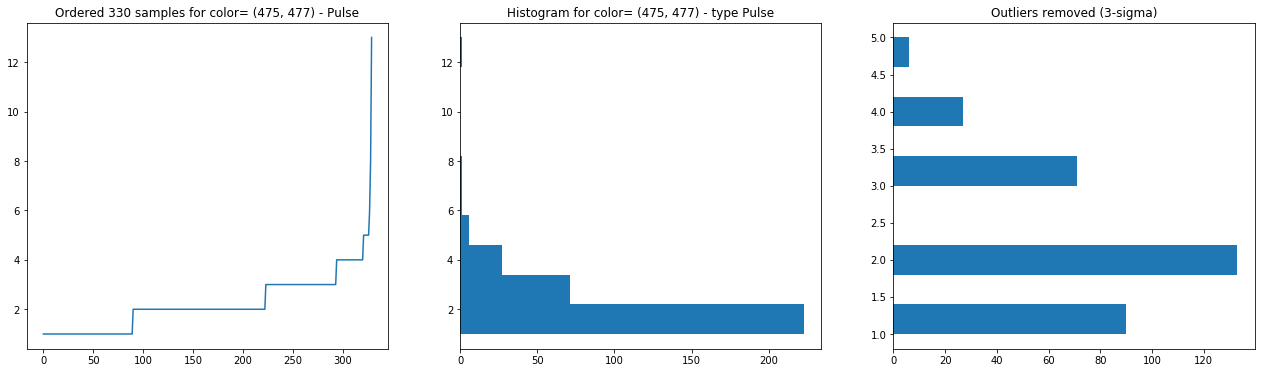

color 477:
[CONTROL/${ANT}/cppContainer-GL - ] Switched state of component CONTROL/${ANT}/TOTALPOWER: INITIALIZING -> INITIALIZED

color 480:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT})



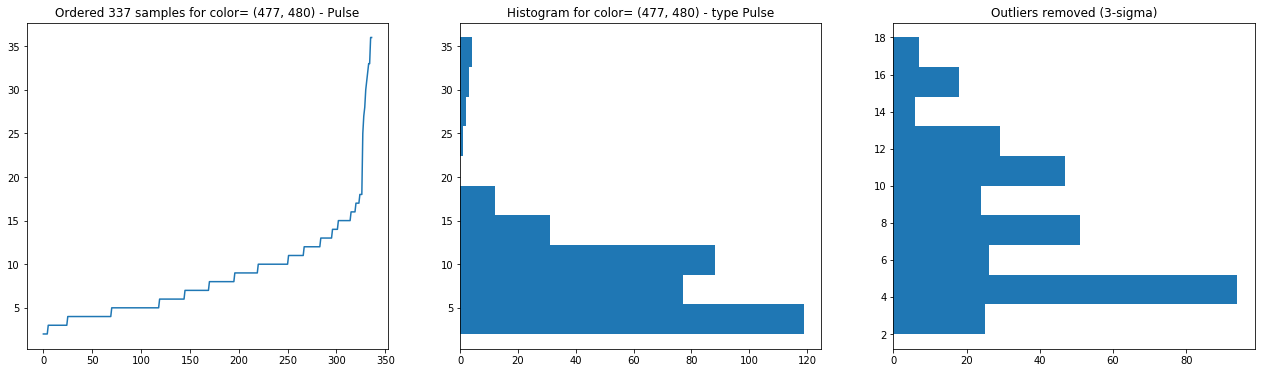

color 480:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT})

color 482:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)



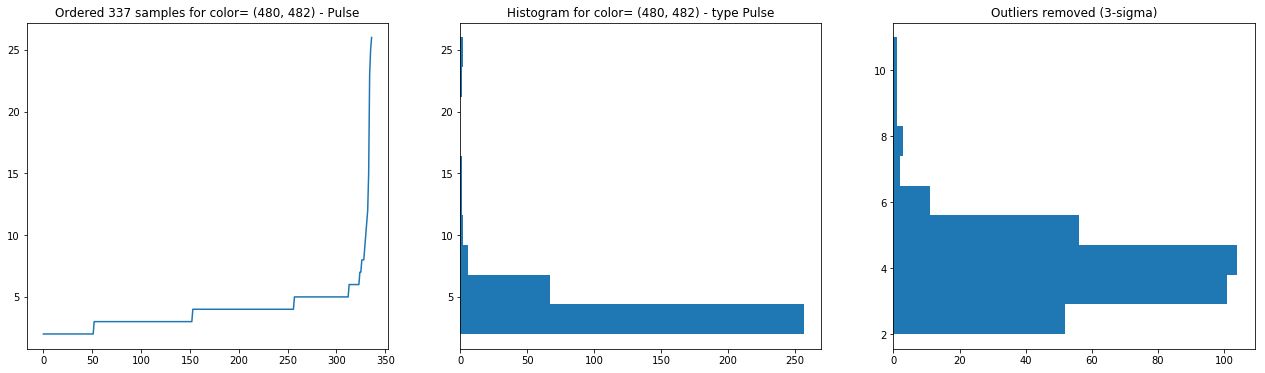

In [105]:
multiplot(475, 477) ; multiplot(477, 480) ; multiplot(480, 482) 

Then this dataset should exists and be < N * PULSE_VALUE

color 475:
[maci::LibraryManager - maci::LibraryManager::load] Loaded '${PATH}/libTotalPowerImpl.so'.

color 482:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)



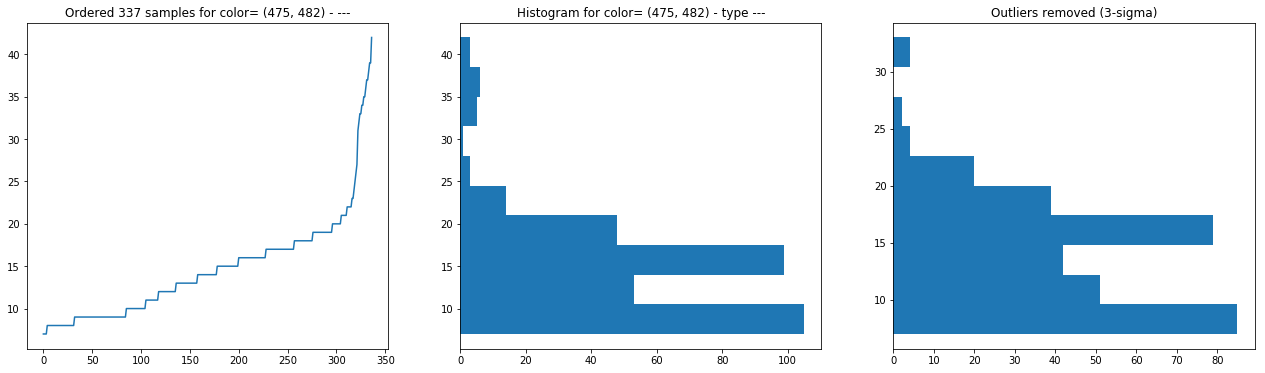

In [106]:
multiplot(475, 482)

And moreover, all subpaths should exists and its max values be less than N*PULSE_VALUE

color 475:
[maci::LibraryManager - maci::LibraryManager::load] Loaded '${PATH}/libTotalPowerImpl.so'.

color 480:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT})



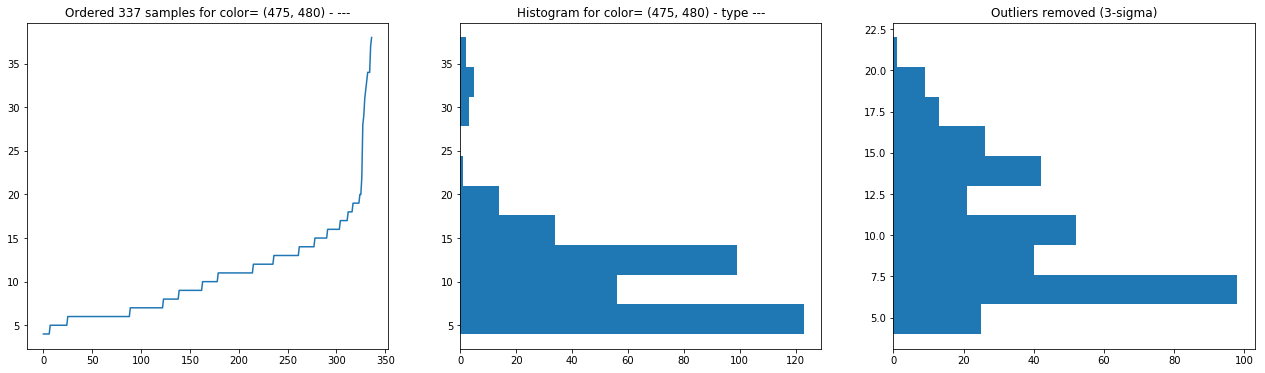

color 477:
[CONTROL/${ANT}/cppContainer-GL - ] Switched state of component CONTROL/${ANT}/TOTALPOWER: INITIALIZING -> INITIALIZED

color 482:
[CONTROL/${ANT}/TOTALPOWER - ] ContainerServices::getComponentNonSticky(CONTROL/${ANT}/IFProc_B)



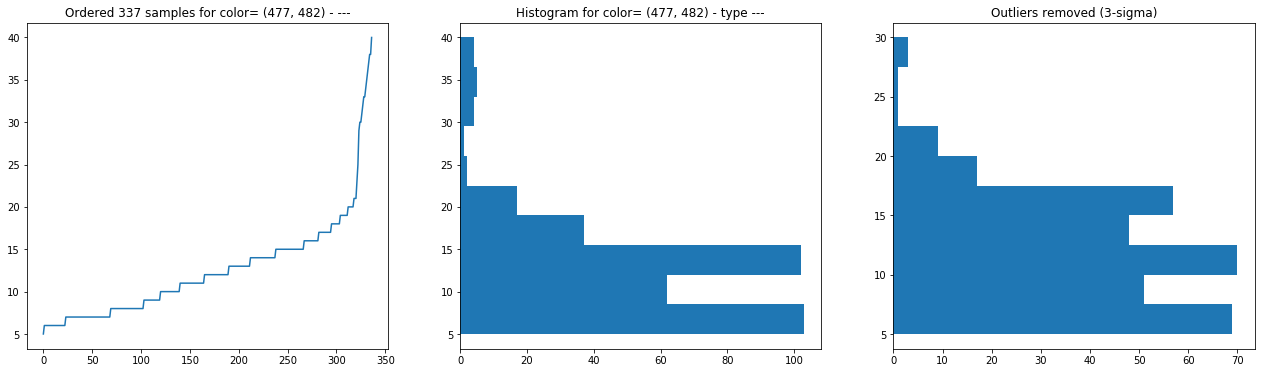

In [107]:
#multiplot(475, 477) ; multiplot(477, 480) ; multiplot(480, 482) 
multiplot(475, 480) ; multiplot(477, 482) 

color 503:
[CONTROL/${ANT}/FrontEnd - void FrontEndImpl::optimizeSinglePolInternal(ReceiverBandMod::ReceiverBand, int, float&, float&)] Pol${N}: ijc=${N},ij${N}=${N},ij${N}=${N}

color 507:
[CONTROL/${ANT}/FrontEnd - void FrontEndImpl::optimizeSinglePolInternal(ReceiverBandMod::ReceiverBand, int, float&, float&)] vd${N}=${N}[V] yavg=${N}[uA] e${N}=${N}[uA]



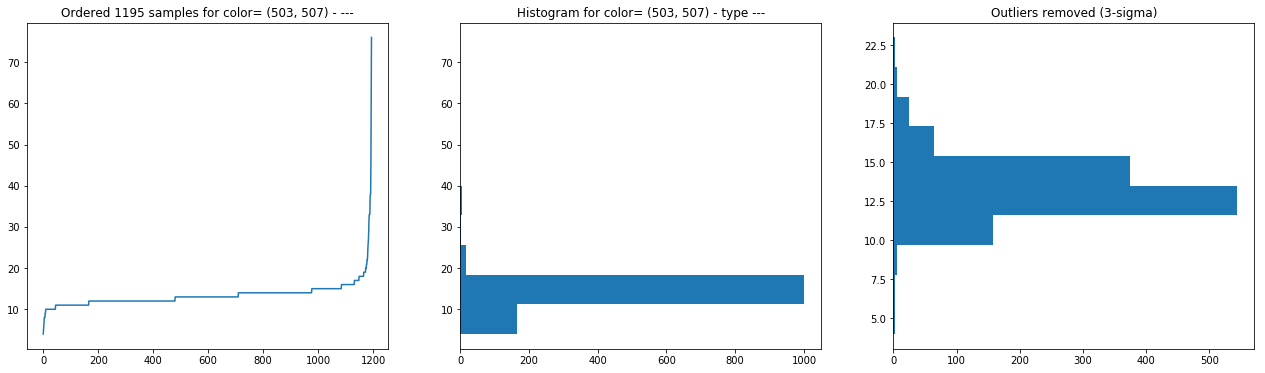

In [129]:
multiplot(503, 507)